# Supervised dual variable learning
*This notebook is for google colab implementation*

In [ ]:
# prompt: load folder from google drive folder layered-ac-main

import os

# Replace 'layered-ac-main' with the actual folder name in your Google Drive
folder_path = '/content/drive/My Drive/layered-ac-main'
from google.colab import drive
drive.mount('/content/drive/')
# Check if the folder exists
if os.path.exists(folder_path):
  # List the contents of the folder
  print(f"Contents of '{folder_path}':")
  for item in os.listdir(folder_path):
    print(item)
else:
  print(f"Folder '{folder_path}' not found.")

Mounted at /content/drive/
Contents of '/content/drive/My Drive/layered-ac-main':
.gitignore
README.md
requirements_original.txt
agent
controller
env
notebooks
experiments
runs
requirements.txt
checkpoints
NuMLP_epoch1.pth
NuMLP_epoch1000.pth
NuMLP_epoch2000.pth
NuMLP_epoch3000.pth
NuMLP_epoch4000.pth
NuMLP_epoch5000.pth
NuMLP_epoch6000.pth
NuMLP_epoch7000.pth
NuMLP_epoch8000.pth
NuMLP_epoch9000.pth
NuMLP_epoch10000.pth


In [ ]:
%cd /content/drive/My Drive/layered-ac-main

/content/drive/My Drive/layered-ac-main


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 啟用 autoreload
%load_ext autoreload
%autoreload 2

## linear with contoller

In [ ]:
import env.dynamics.linear as linear
from controller.ilqrtrackingctrl import ILQRtrackingcontroller
from agent.numlp import NuMLP, NuMLPHelper

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Option 1 Random linearized dynamics

In [ ]:
# Define system dynamics (Double Integrator Model)
dt = 0.1
Nx = 4
Nu = 2
T = 20

# random seed
# seed = 42
# torch.manual_seed(seed)

# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
seed = None

# Define Dynamics
dynamics = linear.sample_linear_dynamics(Nx, Nu, A_norm=1.0, device = device, seed = seed)

In [ ]:
print(dynamics.A)
print(dynamics.B)

tensor([[ 0.3319, -0.3649,  0.3269,  0.3289],
        [ 0.1341, -0.1148, -0.2363, -0.2755],
        [ 0.5585, -0.0331, -0.0817,  0.0590],
        [ 0.5823,  0.1127, -0.1206,  0.4320]], device='cuda:0')
tensor([[ 0.5118,  0.3054],
        [ 0.0837,  0.2545],
        [ 0.5221, -0.4979],
        [ 0.6383, -0.1392]], device='cuda:0')


# Option 2 simple kinemetic linear model

In [ ]:
# Define system dynamics (Double Integrator Model)
dt = 0.1
Nx = 4
Nu = 2
T = 20

A = torch.tensor([
    [1.0, 0.0, dt, 0.0],
    [0.0, 1.0, 0.0, dt],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
], device = device)
B = torch.tensor([
    [0.0, 0.0],
    [0.0, 0.0],
    [dt, 0.0],
    [0.0, dt]
], device = device)


dynamics = linear.LinearDynamics(A, B)

# Option 1 iLQR tracking controller

In [ ]:
# Define Q as a diagonal matrix with specified diagonal elements
Q = torch.diag(torch.tensor([10.0, 10.0, 0.0, 0.0]))

# Scale Q by 10 to get Qf
Qf = Q * 5

# Define R as a 2x2 identity matrix scaled by 0.1
R = torch.eye(2) * 0.1
controller = ILQRtrackingcontroller(dynamics, Q, R, Qf, dt=dt, device=device)

# Option 2 lq tracking controller

In [ ]:
# Q = torch.diag(torch.tensor([1.0, 1.0, 0.0, 0.0]))
# R = torch.eye(2) * 0.01
# controller = LQTrackingController(Q = Q, R = R, A = dynamics.A, B = dynamics.B, horizon = T)

In [ ]:
def generate_reference_trajectories(batch_size, T, step_length=1):
    """ Generate batch of reference trajectories with specified increments.
    Returns:
    r_traj: (batch_size, T, Nx)
    """
    Nx = 4  # [x, y, vx, vy]
    r_traj = torch.zeros(batch_size, T, Nx, device=device)
    # Random initial positions in [0, 1)
    x0 = torch.rand(batch_size, 2, device=device)
    # Zero initial velocities
    v0 = torch.tensor([1.5, 0], device=device).unsqueeze(0).repeat(batch_size, 1)
    # Possible increments for x and y
    x_increments = torch.tensor([1, 2], device=device, dtype=torch.float)
    y_increments = torch.tensor([-1, 0, 1], device=device, dtype=torch.float)
    for i in range(batch_size):
        pos = x0[i]
        vel = v0[i]
        r_traj[i, 0, :2] = pos
        r_traj[i, 0, 2:] = vel  # Velocities are zero
        for t in range(1, T):
            # Randomly select increments from the specified sets
            delta_x = x_increments[torch.randint(0, len(x_increments), (1,))]
            delta_y = y_increments[torch.randint(0, len(y_increments), (1,))]
            delta_pos = torch.stack((delta_x, delta_y)).squeeze()
            pos = pos + delta_pos
            r_traj[i, t, :2] = pos
            r_traj[i, t, 2:] = vel  # Keep velocity zero
    return r_traj

In [ ]:
def generate_training_data(batch_size, T, dynamics, controller):
    """ Generate training data
    Returns:
    x_t: (batch_size, Nx)
    delta_r: (batch_size, Nx)
    """
    # Generate reference trajectories
    r_traj = generate_reference_trajectories(batch_size, T + 1)
    # Initial states x0 = r_traj[0]
    x0 = r_traj[:, 0, :]

    # Reference of control output is setting to be zero defaultly
    u_ref_traj = torch.zeros(batch_size, T, Nu, device=device)
    u0 = torch.zeros(batch_size, T, Nu, device=device)

    # Use controller to get control inputs
    u_exac, x_exac = controller.solve(x0, u0, r_traj, u_ref_traj, max_iters=max_iters, tol=tol, alpha=alpha)

    # Compute delta_r = r_t - x_t
    delta_r = r_traj - x_exac

    return r_traj, delta_r

# (Optional) check the original controller performance

iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
Tracking Error before adjustment: 61.6495


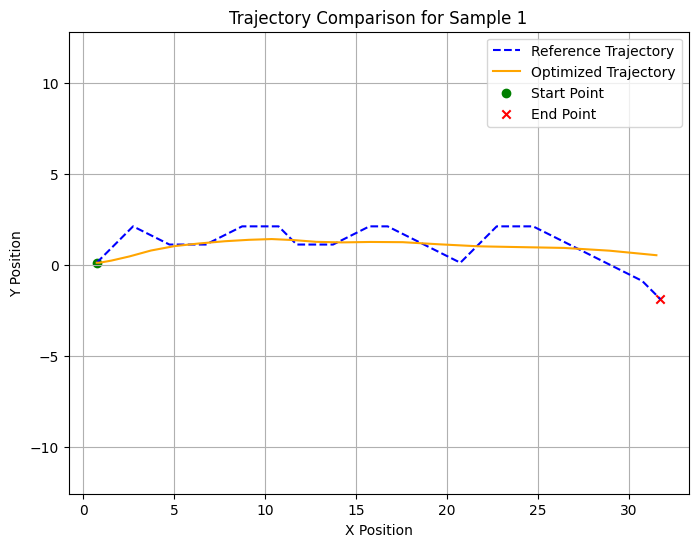

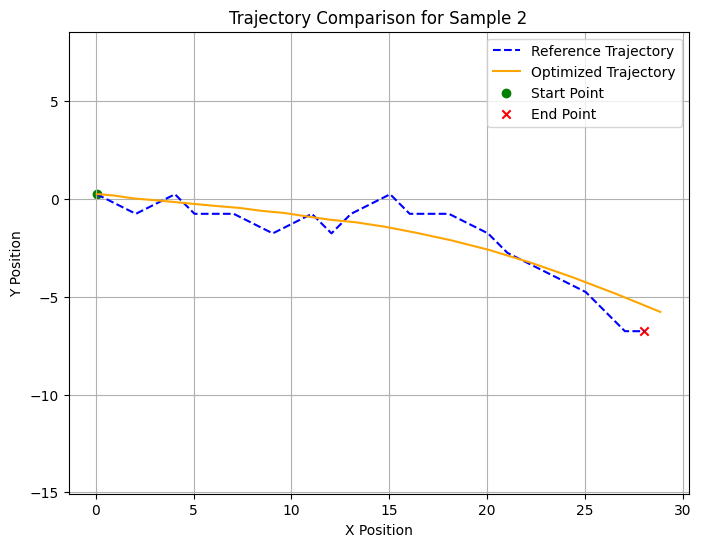

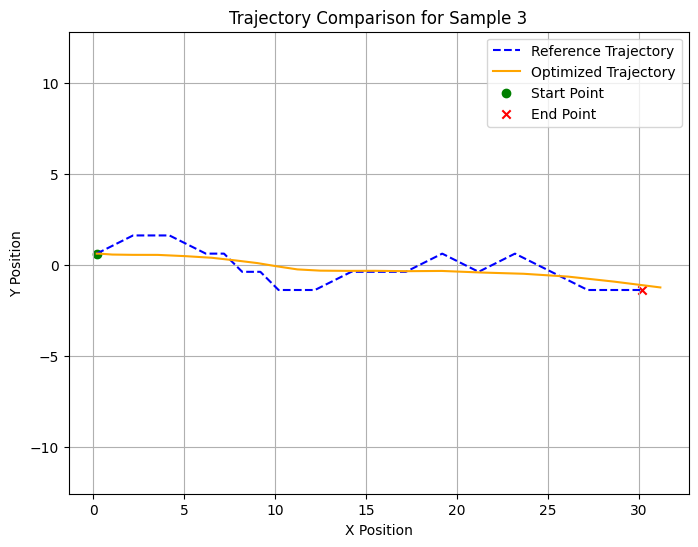

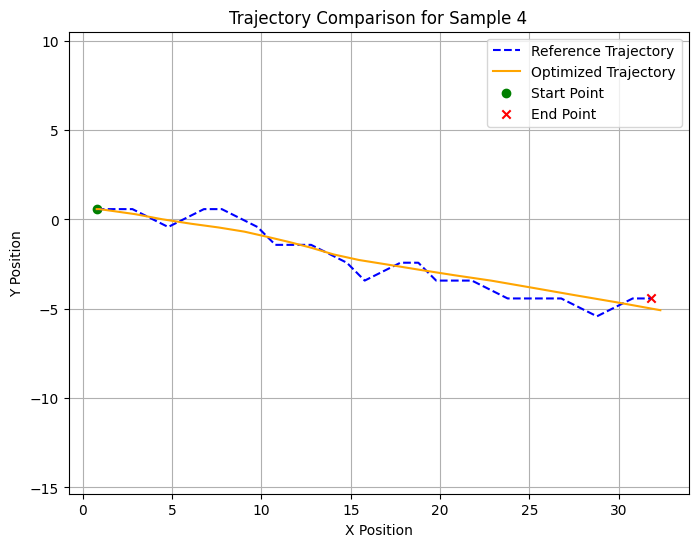

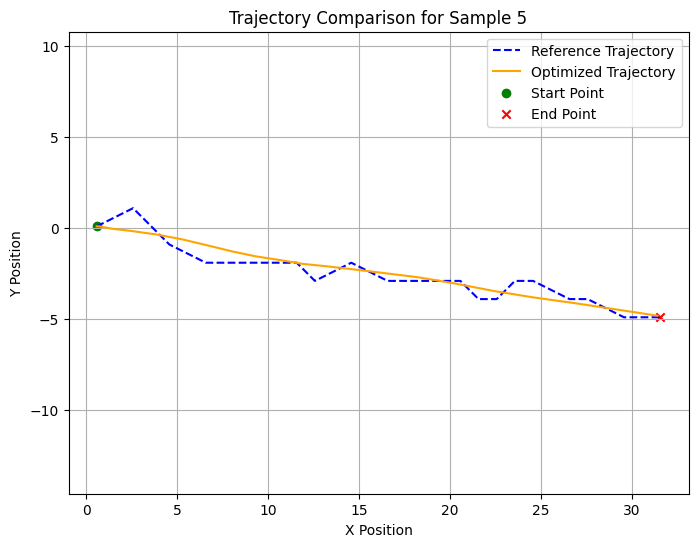

In [ ]:
# Controller performance
n = 10
max_iters=20
tol=1e-1
alpha=0.1
controller.plot_solver_performance(batch_size = n, generate_training_data_func = generate_training_data, T = T, dynamics = dynamics, controller = controller, max_iters=max_iters, tol=tol, alpha=alpha)

In [ ]:
# Define neural network parameters
input_size = dynamics.Nx * (T + 1)  # Flattened reference trajectory
output_size = dynamics.Nx * (T + 1) # Flattened delta_r over the T
hidden_size = 128  # You can adjust this based on your requirements

# Initialize the neural network model
model = NuMLP(input_size, output_size, hidden_size=hidden_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Initialize the helper class
helper = NuMLPHelper(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dynamics=dynamics,
    controller=controller,
    horizon=T,
    device=device
)

# Training parameters
num_epochs = 10000
batch_size = 64

# Train the model
helper.train_model(
    num_epochs=num_epochs,
    batch_size=batch_size,
    generate_training_data_func=generate_training_data,
    checkpoint_interval=1000  # Save model every 10 epochs
)

# Validate the model
helper.validate_model(
    batch_size=batch_size,
    generate_training_data_func=generate_training_data
)
# Close the TensorBoard writer
helper.close_writer()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


iLQR solver reaches the maximum iterations
Epoch [1/10000], Loss: 62.4436
Model checkpoint saved at NuMLP_epoch1.pth
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the maximum iterations
iLQR solver reaches the

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./runs

## Unicycle with ilqr tracking contoller

In [ ]:
from env.dynamics.unicycle import UnicycleDynamics
from controller.ilqrtrackingctrl import ILQRtrackingcontroller
from agent.numlp import NuMLP, NuMLPHelper

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Option 1 Unicycle Dynamics

In [ ]:
# Define system dynamics (Double Integrator Model)
dt = 0.1
sample_step = 1
Nx = 4
Nu = 2
T = 20
dynamics = UnicycleDynamics(dt=dt)

# Option 1 iLQR tracking controller

In [ ]:
# Define Q as a diagonal matrix with specified diagonal elements
Q = torch.diag(torch.tensor([10.0, 10.0, 0, 0]))

# Scale Q to get Qf
Qf = torch.diag(torch.tensor([250.0, 250.0, 10, 10]))

R = torch.diag(torch.tensor([1, 0.1]))

ctrlr_validity_tol = 15

# set speed and theta intial
v_init = [1.5 * sample_step / dt, 0]
controller = ILQRtrackingcontroller(dynamics, Q, R, Qf, dt=dt, device=device)

In [ ]:
# Set contoller hyper
max_iters=20
tol=1e-1
alpha=0.2

# Option 2 lq tracking controller

In [ ]:
# Q = torch.diag(torch.tensor([1.0, 1.0, 0.0, 0.0]))
# R = torch.eye(2) * 0.01
# controller = LQTrackingController(Q = Q, R = R, A = dynamics.A, B = dynamics.B, horizon = T)

In [ ]:
def generate_reference_trajectories(batch_size, T, step_length=1):
    """ Generate batch of reference trajectories with specified increments.
    Returns:
    r_traj: (batch_size, T, Nx)
    """
    Nx = 4  # [x, y, vx, vy]
    r_traj = torch.zeros(batch_size, T, Nx, device=device)
    # Random initial positions in [0, 1)
    x0 = torch.rand(batch_size, 2, device=device)
    # initial velocities and heading
    v0 = torch.tensor(v_init, device=device).unsqueeze(0).repeat(batch_size, 1)
    # Possible increments for x and y
    x_increments = torch.tensor([sample_step, 2 * sample_step], device=device, dtype=torch.float)
    y_increments = torch.tensor([-sample_step, 0, sample_step], device=device, dtype=torch.float)
    for i in range(batch_size):
        pos = x0[i]
        vel = v0[i]
        r_traj[i, 0, :2] = pos
        r_traj[i, 0, 2:] = vel  # Velocities are zero
        for t in range(1, T):
            # Randomly select increments from the specified sets
            delta_x = x_increments[torch.randint(0, len(x_increments), (1,))]
            delta_y = y_increments[torch.randint(0, len(y_increments), (1,))]
            delta_pos = torch.stack((delta_x, delta_y)).squeeze()
            pos = pos + delta_pos
            r_traj[i, t, :2] = pos
            r_traj[i, t, 2:] = vel  # Keep velocity zero
    r_traj[:, -1, 2:] = v0
    return r_traj

In [ ]:
def generate_training_data(batch_size, T, dynamics, controller, ctrlr_validity_tol=ctrlr_validity_tol, max_iters=max_iters, tol=tol, alpha=alpha):
    """ Generate training data
    Returns:
    x_t: (batch_size, Nx)
    delta_r: (batch_size, Nx)
    """
    # Generate reference trajectories
    r_traj = generate_reference_trajectories(batch_size, T + 1)
    # Initial states x0 = r_traj[0]
    x0 = r_traj[:, 0, :]

    # Reference of control output is setting to be zero defaultly
    u_ref_traj = torch.zeros(batch_size, T, Nu, device=device)
    u0 = torch.zeros(batch_size, T, Nu, device=device)

    # Use controller to get control inputs
    u_exac, x_exac = controller.solve(x0, u0, r_traj, u_ref_traj, max_iters=max_iters, tol=tol, alpha=alpha)

    # Compute delta_r = r_t - x_t
    delta_r = r_traj - x_exac
    # Compute the Euclidean distance between final x_exac and r_traj for each sample
    final_error = torch.norm(x_exac[:, -1, :2] - r_traj[:, -1, :2], dim=1)  # Shape: (batch_size,)
    # Create a mask where error <= tol
    mask = final_error <= ctrlr_validity_tol

    # Filter the data using the mask
    r_traj_filtered = r_traj[mask]
    delta_r_filtered = delta_r[mask]

    # # Log the number of filtered samples
    # num_filtered = batch_size - r_traj_filtered.size(0)
    # print(f"Filtered out {num_filtered} samples due to final position error exceeding tolerance.")

    return r_traj, delta_r

# (Optional) check the original controller performance

Tracking Error before adjustment: -0.0026


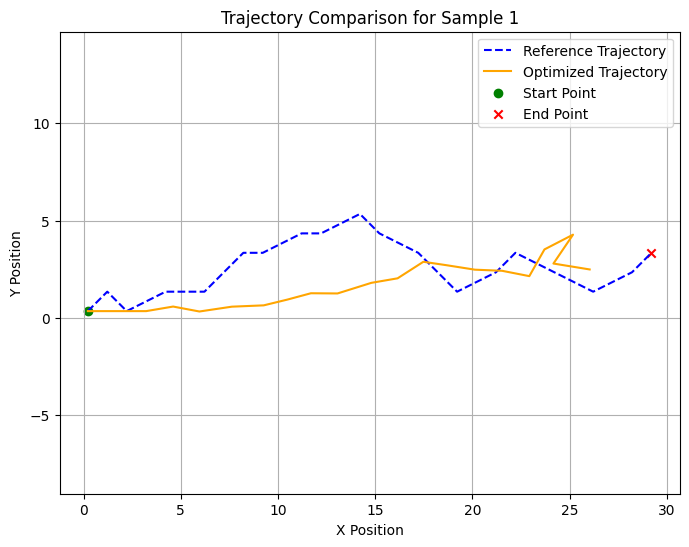

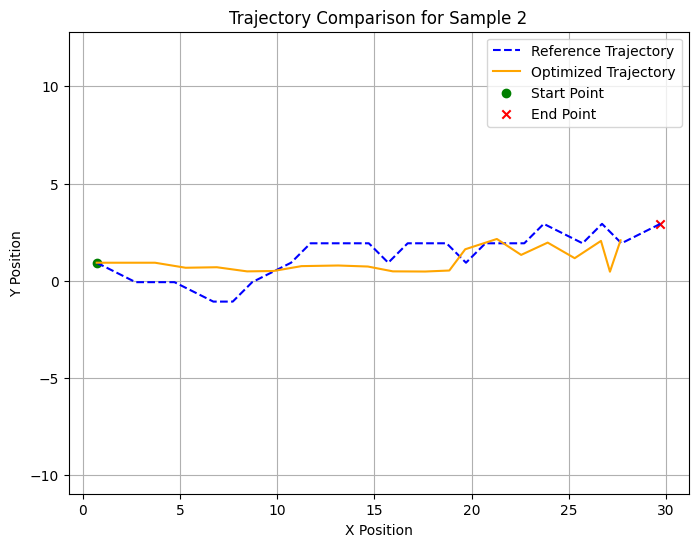

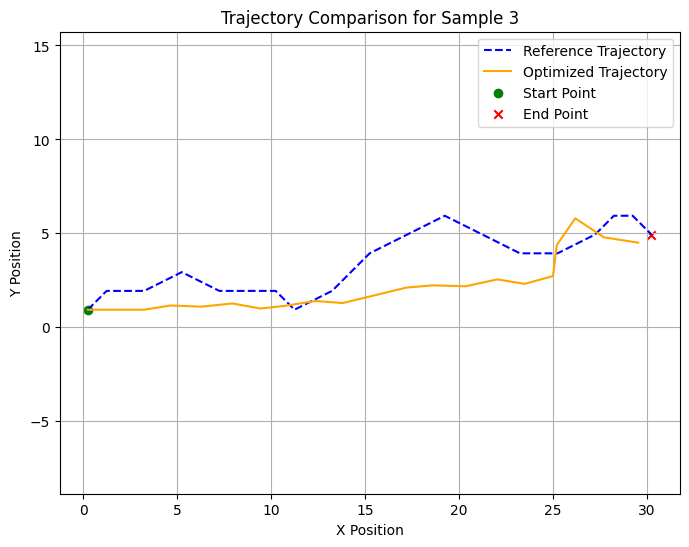

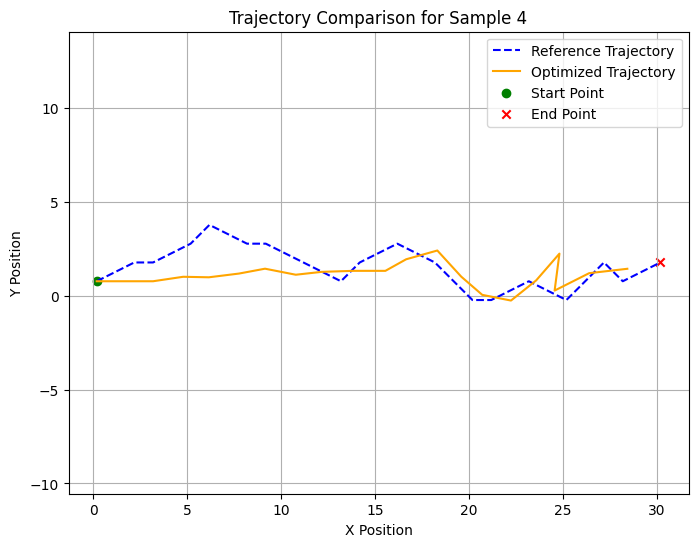

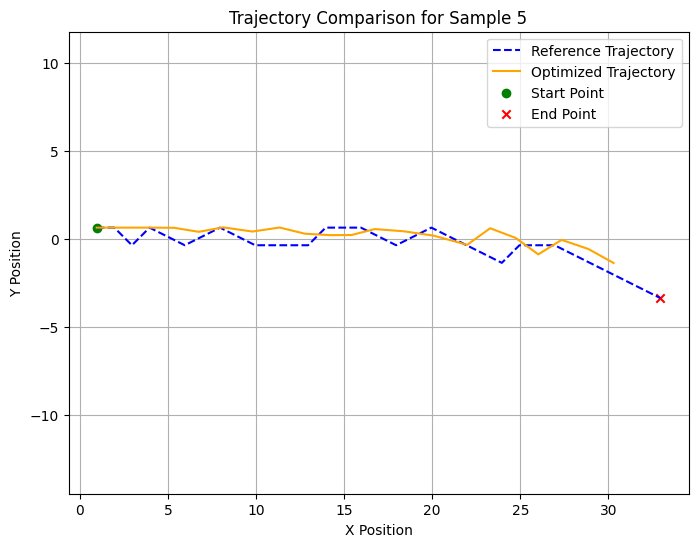

In [ ]:
# Controller performance
n = 5
controller.plot_solver_performance(batch_size = n, generate_training_data_func = generate_training_data, T = T, dynamics = dynamics, controller = controller, max_iters=max_iters, tol=tol, alpha=alpha)

In [ ]:
# Define neural network parameters
input_size = dynamics.Nx * (T + 1)  # Flattened reference trajectory
output_size = dynamics.Nx * (T + 1) # Flattened delta_r over the T
hidden_size = 128  # You can adjust this based on your requirements

# Initialize the neural network model
model = NuMLP(input_size, output_size, hidden_size=hidden_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Initialize the helper class
helper = NuMLPHelper(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dynamics=dynamics,
    controller=controller,
    horizon=T,
    device=device
)

# Training parameters
num_epochs = 10000
batch_size = 64

# Train the model
helper.train_model(
    num_epochs=num_epochs,
    batch_size=batch_size,
    generate_training_data_func=generate_training_data,
    checkpoint_interval=1000  # Save model every 10 epochs
)

# Validate the model
helper.validate_model(
    batch_size=batch_size,
    generate_training_data_func=generate_training_data,
    max_iters=max_iters,
    tol=tol,
    alpha=alpha
)
# Close the TensorBoard writer
helper.close_writer()

Epoch [1/10000], Loss: 4.0730
Model checkpoint saved at NuMLP_epoch1.pth
Epoch [50/10000], Loss: 1.5870
Epoch [100/10000], Loss: 1.2888
Epoch [150/10000], Loss: 1.2192
Epoch [200/10000], Loss: 1.0911
Epoch [250/10000], Loss: 1.0412
Epoch [300/10000], Loss: 1.1126
Epoch [350/10000], Loss: 1.0565
Epoch [400/10000], Loss: 0.9450
Epoch [450/10000], Loss: 0.9216
Epoch [500/10000], Loss: 0.9082
Epoch [550/10000], Loss: 0.9230
Epoch [600/10000], Loss: 0.8540
Epoch [650/10000], Loss: 0.9134
Epoch [700/10000], Loss: 0.8572
Epoch [750/10000], Loss: 0.8443
Epoch [800/10000], Loss: 0.8414
Epoch [850/10000], Loss: 0.8011
Epoch [900/10000], Loss: 0.7879
Epoch [950/10000], Loss: 0.8545
Epoch [1000/10000], Loss: 0.8207
Model checkpoint saved at NuMLP_epoch1000.pth
Epoch [1050/10000], Loss: 0.7259
Epoch [1100/10000], Loss: 0.7848
Epoch [1150/10000], Loss: 0.7167
Epoch [1200/10000], Loss: 0.7718
Epoch [1250/10000], Loss: 0.9455
Epoch [1300/10000], Loss: 0.7099
Epoch [1350/10000], Loss: 0.7071
Epoch [140

NameError: name 'model' is not defined

In [ ]:
# Initialize the helper class
helper = NuMLPHelper(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dynamics=dynamics,
    controller=controller,
    horizon=T,
    device=device
)

In [ ]:
checkpoint_path = 'NuMLP_epoch10000.pth'  # Replace with your checkpoint file
helper.load_model(checkpoint_path)

Model loaded from NuMLP_epoch10000.pth


Loss(unadjusted_xtraj - adjusted_rtraj): 0.2437
Tracking Error before adjustment: 2.6119
Tracking Error after adjustment: 101.8319


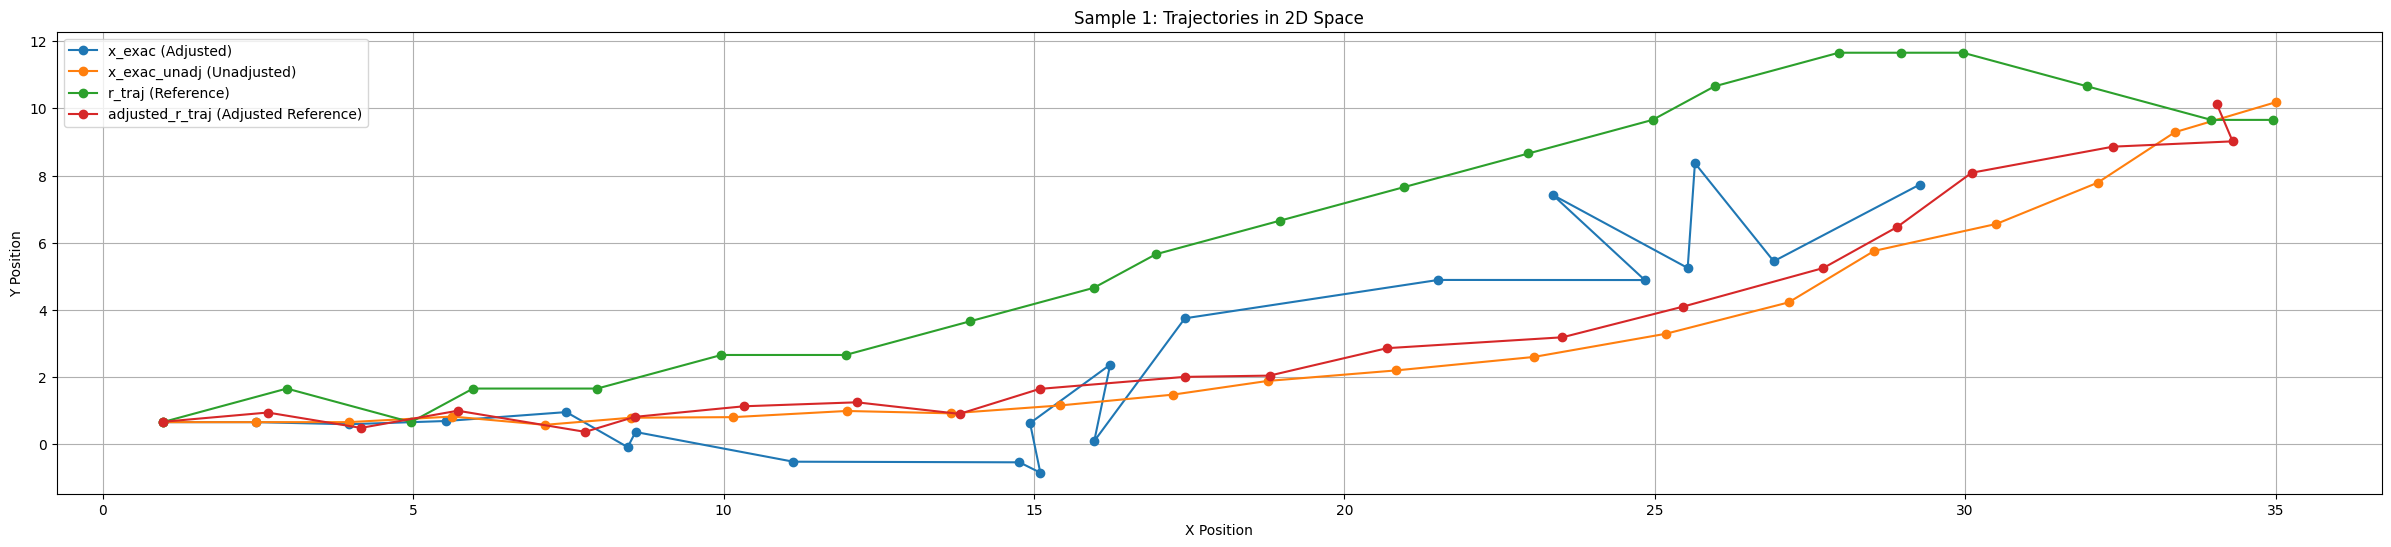

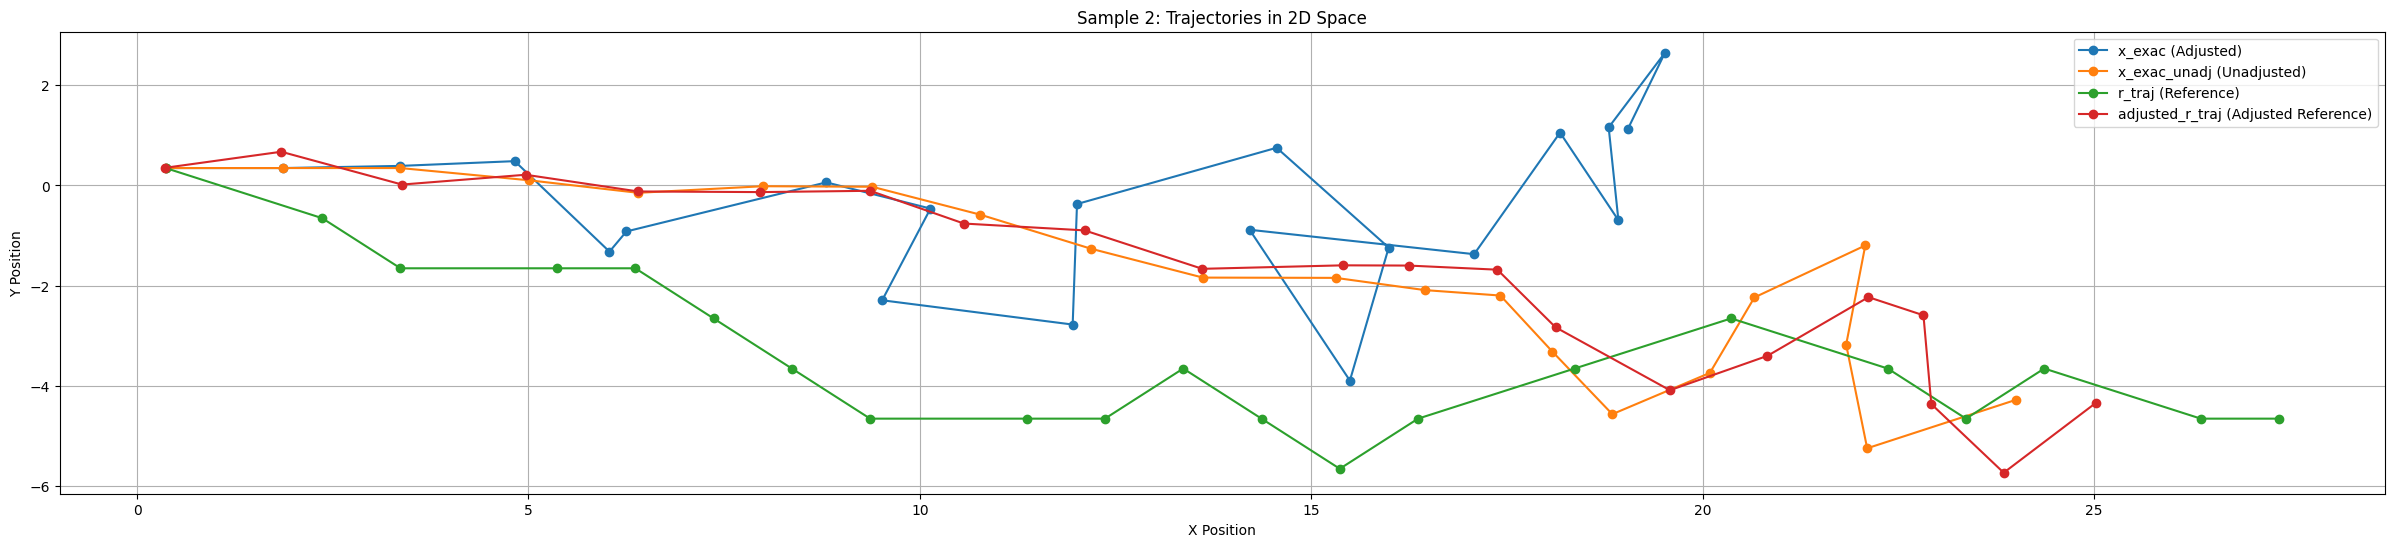

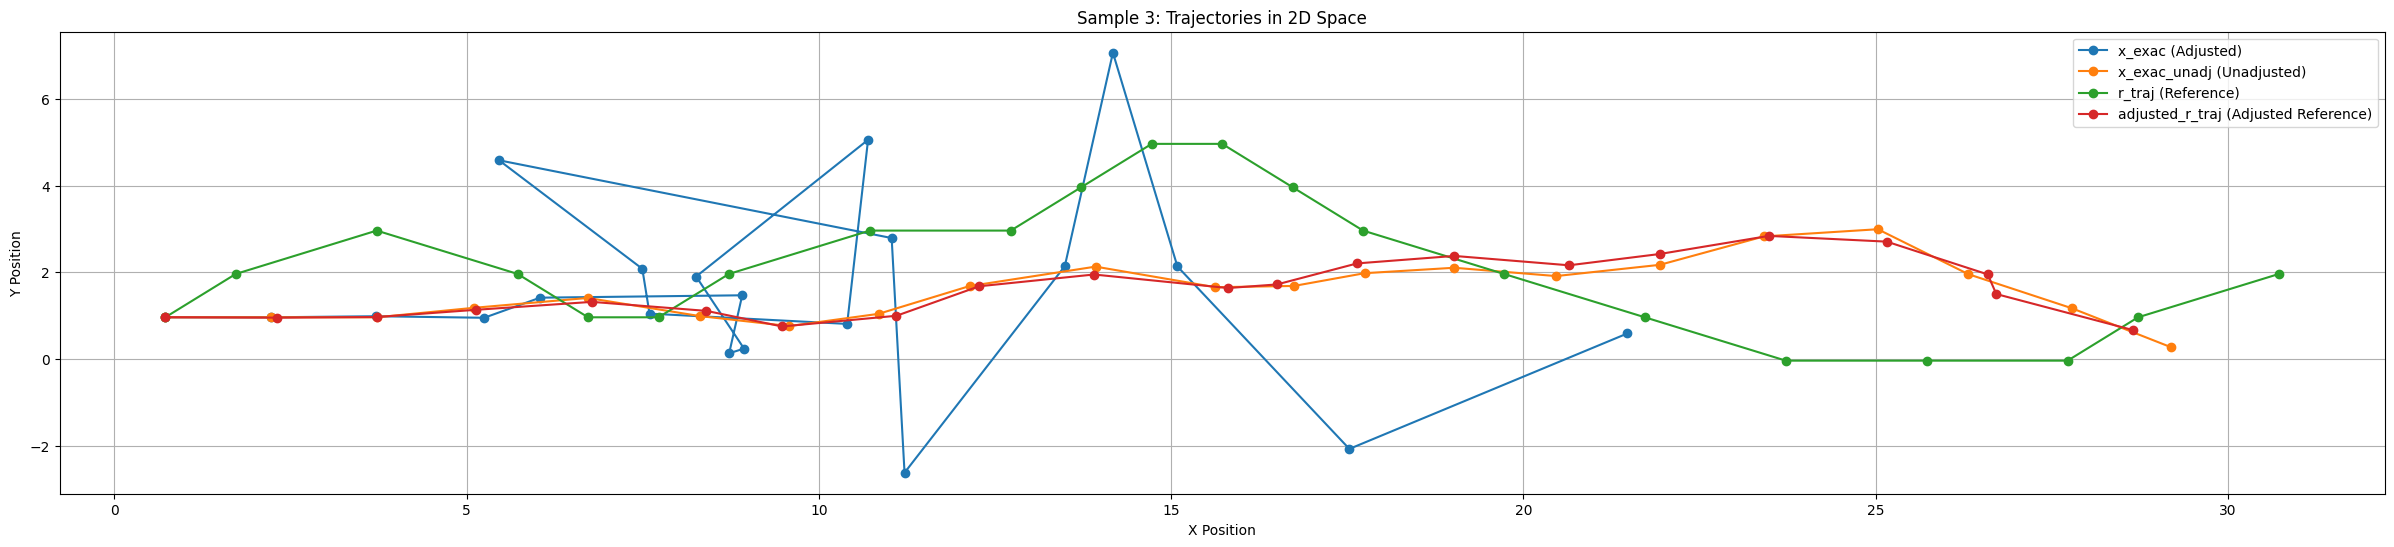

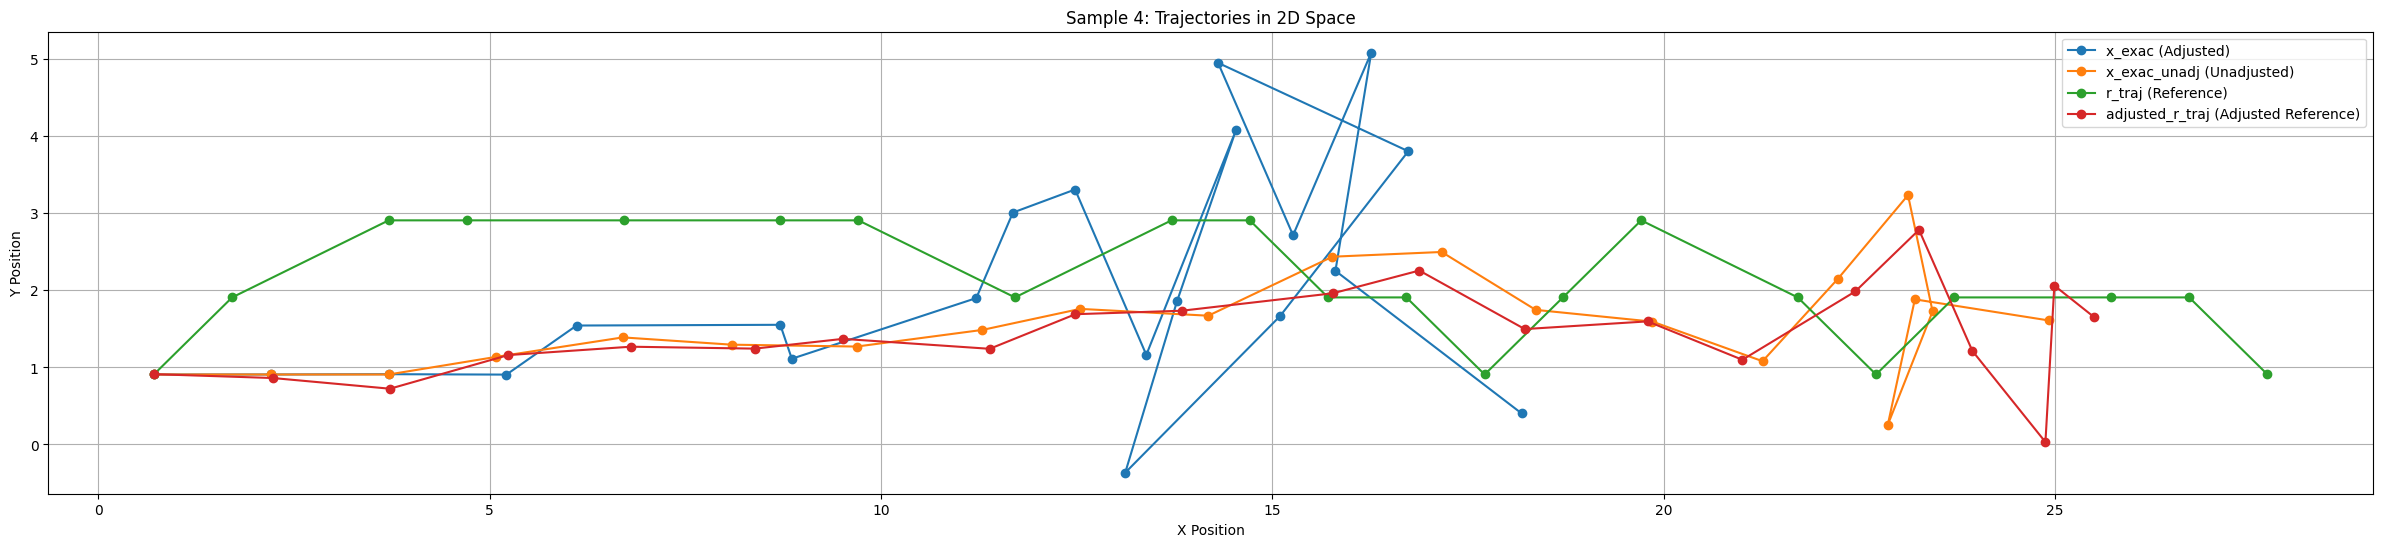

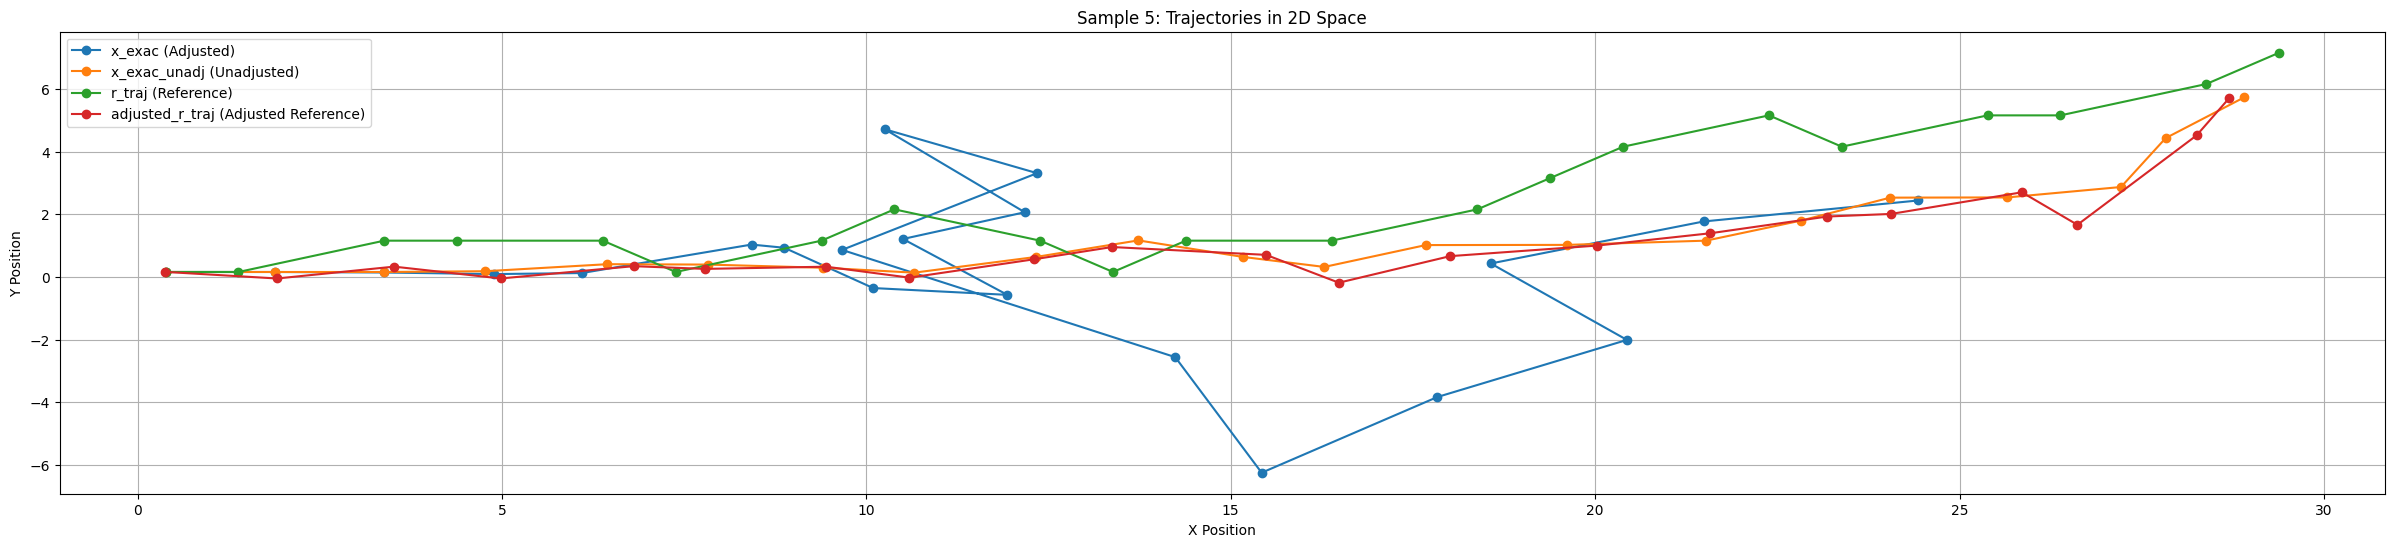

In [ ]:
# Validate the model
batch_size = 64
helper.validate_model(
    batch_size=batch_size,
    generate_training_data_func=generate_training_data,
    max_iters=max_iters,
    tol=tol,
    alpha=alpha
)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./runs